# Run the server script from package data_summarization_1KGP

This time, we are going to select all the individuals originating from the American and South Asian continents, who have two variants located on opposite chromosome copies of the hg19 reference assembly. We refer these variants by their id, as assigned from dbSNP. 

In [1]:
import json
param = \
{'meta': {
    'super_population': ['AMR', 'SAS'],
    'assembly': 'hg19'
    },
 'variants': {
     'on_diff_chrom_copy': [{'id': 'rs367896724'}, {'id': 'rs555500075'}]
 }
}
body = json.dumps(param)
print(body)

{"meta": {"super_population": ["AMR", "SAS"], "assembly": "hg19"}, "variants": {"on_diff_chrom_copy": [{"id": "rs367896724"}, {"id": "rs555500075"}]}}


Given this sample set, we wil ask for the distribution of the variant with id 'rs376342519' with respect to the gender and super-population attributes.

In [2]:
query_param = {
    'id': 'rs376342519',
    'by': 'gender,super_population'
}

POST the endpoint \variant_distribution with the prepared JSON parameter and query parameters.

In [20]:
import requests

r = requests.post('http://127.0.0.1:5000/variant_distribution', json=param, params=query_param)
print(' response status code: {}'.format(r.status_code))
response_body = r.json()

response status code: 200


# Inspect response data:
It's a data cube with the numerosity of the individuals grouped on the free-dimensions: gender, dna_source and population (to be intended as country of origin)

In [21]:
import pandas as pd
from matplotlib import pyplot as plt
columns = response_body['columns']
rows = response_body['rows']
df = pd.DataFrame.from_records(rows, columns=columns)

df.fillna(value='', inplace=True)

df

,occurrence,samples,frequency,gender,super_population
0,393,197,0.997462,,
1,94,47,1.000000,female,SAS
2,140,70,1.000000,male,SAS
3,65,33,0.984848,female,AMR
4,94,47,1.000000,male,AMR
5,234,117,1.000000,male,
6,159,80,0.993750,female,
7,159,80,0.993750,,AMR
8,234,117,1.000000,,SAS


Total count of individuals

In [25]:
total = df.query('super_population == "" & gender == ""')['samples'].iloc[0]
print(total)

197


We notice that the variant rs376342519 has a larger base in the South Asian population.

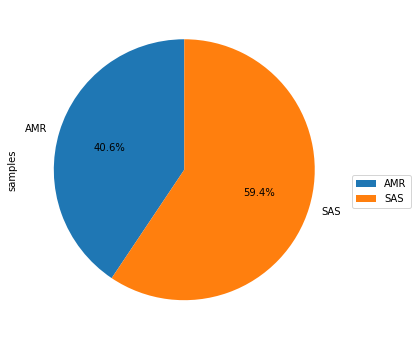

In [33]:
# prepare data frame
df1 = df.drop(df.query('gender != "" | super_population == ""').index)    
df1.drop(['frequency', 'gender', 'occurrence'], inplace=True, axis=1)
df1
pie = df1.plot(
    kind='pie',
    y='samples',
    labels=df1['super_population'].tolist(),
    figsize=(6, 6),
    startangle=90, 
    autopct='%1.1f%%'
)
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()

But this variant is anyway very common, since the frequency in the American continent is 99,3% - less common in females - and 100% in the South Asian one.

Notice that we could have also express all the variants identifier in this notebook also by their coordinates (chrom, start and alternative allele) obtaining the same results.